In [2]:
import random
import numpy as np
from collections import deque

#Initalize minesweeper board 
class MinesweeperBoard:
    def __init__(self, rows, cols, num_mines):
        self.rows = rows
        self.cols = cols
        self.num_mines = num_mines
        self.board = [[0 for _ in range(cols)] for _ in range(rows)]
        self.playerBoard = [[9 for _ in range(cols)] for _ in range(rows)]
        self.generate_mines()

    def update_cell(self, row, col, value):
        self.playerBoard[row][col] = value

    def set_cell(self, row, col, value):
        self.board[row][col] = value

    def is_valid_cell(self, row, col):
        return 0 <= row < self.rows and 0 <= col < self.cols

    def generate_mines(self):
        mines_generated = 0
        while mines_generated < self.num_mines:
            row = random.randint(0, self.rows - 1)
            col = random.randint(0, self.cols - 1)
            if self.board[row][col] != -1:
                self.board[row][col] = -1
                mines_generated += 1
                self.update_adjacent_cells(row, col)

    def update_adjacent_cells(self, row, col):
        for i in range(max(0, row - 1), min(self.rows, row + 2)):
            for j in range(max(0, col - 1), min(self.cols, col + 2)):
                if self.board[i][j] != -1:
                    self.board[i][j] += 1

    def query(self, row, col):
        return self.board[row][col]
    
    def query_player(self, row, col):
        return self.playerBoard[row][col]
    
    def display_board(self):
        for row in self.board:
            print(" ".join(str(cell) for cell in row))
    
    def display_boardPlayer(self):
        for row in self.playerBoard:
            print(" ".join(str(cell) for cell in row))

    def get_random_zero_cell(self):
        zero_cells = [(r, c) for r in range(self.rows) for c in range(self.cols) if self.board[r][c] == 0]
        if zero_cells:
            return random.choice(zero_cells)
        else:
            non_mine_cells = [(r, c) for r in range(self.rows) for c in range(self.cols) if self.board[r][c] != -1]
            return random.choice(non_mine_cells)   
        
    def get_tensor(self):
        board_tensor = np.zeros((self.rows, self.cols, 10))
        
        for r in range(self.rows):
            for c in range(self.cols):
                cell_value = self.playerBoard[r][c]
                board_tensor[r, c, cell_value] = 1  
        
        return board_tensor
    
    def get_mine_map(self):
        board_tensor = np.zeros((self.rows, self.cols))
        for r in range(self.rows):
            for c in range(self.cols):
                if self.board[r][c] == -1:
                    board_tensor[r, c] = 1
        return board_tensor
    
    def get_opened_count(self):
        arr = np.array(self.playerBoard)
        return sum([1 if i != 9 else 0 for i in arr.flatten()])

    def open_cell_player(self, row, col):
        if not self.is_valid_cell(row, col) or self.query_player(row, col) != 9:
            return None
        if self.query(row,col) == -1:
            return False 
        else:
            clue = self.query(row, col)
            self.update_cell(row, col, clue)
            if clue == 0:
                for dr in range(row - 1, row + 2):
                    for dc in range(col - 1, col + 2):
                        self.open_cell_player(dr, dc)
            return True

easy = MinesweeperBoard(9, 9, 10)
medium = MinesweeperBoard(16, 16, 40)
hard = MinesweeperBoard(30, 16, 99)

# Example Usage
exampleBoard = MinesweeperBoard(10, 10, 10)
exampleBoard.display_board()


0 1 -1 2 1 2 -1 2 1 1
0 1 1 2 -1 2 2 3 -1 1
0 0 1 3 3 2 1 -1 2 1
0 0 1 -1 -1 2 2 1 1 0
0 0 1 2 3 -1 1 0 0 0
1 1 1 0 1 1 1 0 0 0
1 -1 1 0 0 0 0 0 0 0
1 1 1 0 0 1 1 1 0 0
0 0 0 0 0 1 -1 1 0 0
0 0 0 0 0 1 1 1 0 0


MineSweeper logic bot 

In [4]:
class MinesweeperBot:
    def __init__(self, board):
        self.board = board
        self.cells_remaining = {(r, c) for r in range(board.rows) for c in range(board.cols)}
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.pick_next = set()
        self.clue_number = {}
        self.game_over = False

    def initialize_game(self):
        self.cells_remaining = {(r, c) for r in range(self.board.rows) for c in range(self.board.cols)}
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.pick_next = set()
        self.clue_number = {}
        self.game_over = False

    def query_environment(self):
        if self.inferred_safe:
            row, col = self.inferred_safe.pop()
            if self.board.query_player(row, col) != 9:
                return self.query_environment()
        else:
            if(not self.cells_remaining):
                self.game_over = True
                return -1, -1
            row, col = random.choice(list(self.cells_remaining))
        return row, col
    
    def open_cell(self, row, col):
        if not self.is_valid_cell(row, col) or self.board.query_player(row, col) != 9:
            return None
        if (row, col) in self.cells_remaining:
            self.cells_remaining.remove((row, col))
        if self.board.query(row,col) == -1:
            self.game_over = True
            return False 
        else:
            clue = self.board.query(row, col)
            self.clue_number[(row, col)] = clue
            self.board.update_cell(row, col, clue)
            self.update_cell_sets()
            if clue == 0:
                for dr in range(row - 1, row + 2):
                    for dc in range(col - 1, col + 2):
                        self.open_cell(dr, dc)
            return True
    
    def is_valid_cell(self, row, col):
        return 0 <= row < self.board.rows and 0 <= col < self.board.cols

    def update_cell_sets(self):
        for (row, col) in self.clue_number:
            neighbors = self.get_neighbors(row, col)
            revealed_mines = sum(1 for r, c in neighbors if (r, c) in self.inferred_mine)
            unrevealed_neighbors = [(r, c) for r, c in neighbors if (r, c) in self.cells_remaining]
            revealed_or_safe_count = sum(1 for r, c in neighbors if (r, c) in self.clue_number or (r, c) in self.inferred_safe)
            clue = self.board.query(row,col)
            prevlen = len(self.cells_remaining)

            if clue - revealed_mines == len(unrevealed_neighbors):
                for neighbor in unrevealed_neighbors:
                    self.inferred_mine.add(neighbor)
                    if neighbor in self.cells_remaining:
                        self.cells_remaining.remove(neighbor)

            if (len(neighbors) - clue) - revealed_or_safe_count == len(unrevealed_neighbors):
                for neighbor in unrevealed_neighbors:
                    self.inferred_safe.add(neighbor)
                    if neighbor in self.cells_remaining:
                        self.cells_remaining.remove(neighbor)
        if prevlen != len(self.cells_remaining):
            self.update_cell_sets()

    def get_neighbors(self, row, col):
        neighbors = []
        for r in range(row - 1, row + 2):
            for c in range(col - 1, col + 2):
                if (r, c) != (row, col) and 0 <= r < self.board.rows and 0 <= c < self.board.cols:
                    neighbors.append((r, c))
        return neighbors

    def play_game(self):
        self.initialize_game()
        steps = 0
        mines_triggered = 0
        lstMoves = deque()
        row, col = self.board.get_random_zero_cell()
        while not self.game_over:
            lstMoves.append((row,col))
            if self.open_cell(row, col):
                steps += 1
            else:
                mines_triggered = 1
            row, col = self.query_environment()
        return steps, mines_triggered, lstMoves

    def play_game_nobomb(self):
        self.initialize_game()
        steps = 0
        mines_triggered = 0
        row, col = self.board.get_random_zero_cell()
        while not self.game_over:
            if self.open_cell(row, col):
                steps += 1
            else:
                mines_triggered += 1
                self.game_over = False
            row, col = self.query_environment()
        return steps, mines_triggered
        
    def play_game_NN(self):
        x = deque()
        y = deque()
        self.initialize_game()

        row, col = self.board.get_random_zero_cell()
        while not self.game_over:
            if(not self.open_cell(row, col)):
                break 
            y.append(self.board.get_mine_map())
            x.append(self.board.get_tensor())
            row, col = self.query_environment()
        return x, y 

    def play_game_NN_nobomb(self):
        x = deque()
        y = deque()
        self.initialize_game()

        row, col = self.board.get_random_zero_cell()
        while not self.game_over:
            x.append(self.board.get_tensor())
            y.append(self.board.get_mine_map())
            if(not self.open_cell(row, col)):
                x.pop()
                y.pop() 
                self.game_over = False
            row, col = self.query_environment()
        return x, y       

def iterate_bot(totalGames, row, col, bombs):
    winCount = 0
    totalSteps = 0 
    winLst = []
    stepLst = []
    bombLst = []

    for _ in range(totalGames):
        testBoard = MinesweeperBoard(row, col, bombs) 
        bot = MinesweeperBot(testBoard)
        steps, mines_triggered = bot.play_game()[:2]
        totalSteps += steps
        stepLst.append(steps)
        if mines_triggered == 0:
            winCount += 1
            winLst.append(1)
        else:
            winLst.append(0)

    print("Bot Accuracy easy:", winCount/totalGames)
    print("Bot avg steps easy:", totalSteps/totalGames)

    total_mines = 0
    for _ in range(totalGames):
        testBoard = MinesweeperBoard(row, col, bombs) 
        bot = MinesweeperBot(testBoard)
        mines_triggered = bot.play_game_nobomb()[1]
        total_mines += mines_triggered
        bombLst.append(mines_triggered)
    print("Bot avg mine easy:", total_mines/totalGames)
    print()

    return winLst, stepLst, bombLst

##Win accuracy for logical bot 
totalGames = 1000

winLstEasy, stepLstEasy, bombLstEasy = iterate_bot(totalGames, 9, 9, 10)
winLstIntermediate, stepLstIntermediate, bombLstIntermediate = iterate_bot(totalGames, 16, 16, 40)
winLstExpert, stepLstExpert, bombLstExpert = iterate_bot(totalGames, 30, 16, 99)


Bot Accuracy easy: 0.794
Bot avg steps easy: 16.689
Bot avg mine easy: 0.33

Bot Accuracy easy: 0.504
Bot avg steps easy: 64.125
Bot avg mine easy: 1.417

Bot Accuracy easy: 0.009
Bot avg steps easy: 67.13
Bot avg mine easy: 13.647



Simple MineSweeperUI

In [4]:
import tkinter as tk
from tkinter import messagebox

class MinesweeperUI:
    def __init__(self, master, game):
        self.master = master
        self.game = game
        self.bot = MinesweeperBot(game)
        row, col = self.bot.board.get_random_zero_cell()
        self.buttons = []
        
        self.create_board()
        self.update_ui()
        self.click_cell(row, col)


    def create_board(self):
        self.bombs_label = tk.Label(self.master, text="Total Bombs: {}".format(self.game.num_mines))
        self.bombs_label.grid(row=self.game.rows, column=0, columnspan=self.game.cols // 2)
        
        self.cells_left_label = tk.Label(self.master, text="Cells Left: {}".format(self.game.rows * self.game.cols - self.game.num_mines))
        self.cells_left_label.grid(row=self.game.rows, column=self.game.cols // 2, columnspan=self.game.cols // 2)
        
        for row in range(self.game.rows):
            button_row = []
            for col in range(self.game.cols):
                button = tk.Button(self.master, width=2)
                button.grid(row=row, column=col)
                button.bind('<Button-1>', lambda event, r=row, c=col: self.click_cell(r, c))
                button.bind('<Button-3>', lambda event, r=row, c=col: self.flag_cell(r, c))
                button_row.append(button)
            self.buttons.append(button_row)

    def click_cell(self, row, col):
        value = self.game.query_player(row, col)
        if value != 9:
            return
        cell_value = self.game.query(row, col)
        if cell_value == -1:
            self.reveal_board()
            messagebox.showinfo("Game Over", "You hit a mine! Game over.")
        else:
            self.bot.open_cell(row, col)
            self.update_ui()
            opened_count = self.game.get_opened_count()
            cells_left = self.game.rows * self.game.cols - self.game.num_mines - opened_count
            self.cells_left_label.config(text="Cells Left: {}".format(cells_left))
            if opened_count == self.game.rows * self.game.cols - self.game.num_mines:
                messagebox.showinfo("Congratulations", "You win!")

    def flag_cell(self, row, col):
        current_value = self.game.query_player(row, col)
        if current_value == 9:
            if current_value != "F":
                self.game.update_cell(row, col, "F") 
        if current_value == 'F':
            self.game.update_cell(row, col, 9)
        self.update_ui()

    def reveal_board(self):
        for row in range(self.game.rows):
            for col in range(self.game.cols):
                cell_value = self.game.query(row, col)
                self.game.update_cell(row, col, cell_value)
        self.update_ui()

    def update_ui(self):
        for row in range(self.game.rows):
            for col in range(self.game.cols):
                cell_value = self.game.query_player(row, col)
                if cell_value == 9:
                    self.buttons[row][col].config(text="", state="normal", bg="light green")
                elif cell_value == "F":
                    self.buttons[row][col].config(text="F", state="disabled", bg="light blue")
                else:
                    self.buttons[row][col].config(text=str(cell_value), state="disabled", bg="SystemButtonFace")

def start_game(rows, cols, num_mines):
    root = tk.Tk()
    root.title("Minesweeper")
    game = MinesweeperBoard(rows, cols, num_mines)
    MinesweeperUI(root, game)
    root.mainloop()

start_game(9, 9, 10)


Part 1 minesweeper prediction

    -Test for easy bot 

In [ ]:
#Neural Network 

#Data generation 
import torch

def create_training_data(num_games, rowBoard, colBoard, bomb):
    X_data = deque()  
    y_data = deque() 

    for _ in range(num_games):
        board = MinesweeperBoard(rowBoard, colBoard, bomb) 
        bot = MinesweeperBot(board)

        x, y = bot.play_game_NN()
        X_data.extend(x)
        y_data.extend(y)

    X_data = np.stack(X_data)
    X_data = torch.tensor(X_data)
    y_data = torch.tensor(y_data)
    X_data = X_data.float()
    y_data = y_data.float()

    return X_data, y_data


num_games = 20000
X_data, y_data = create_training_data(num_games, 9, 9, 10)

print("Shape of x:", X_data.shape)
print("Shape of y:", y_data.shape)



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, row, col):
        super(CNNModel, self).__init__()
        self.row = row 
        self.col = col
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size=3, padding = 1)
        self.fc1 = nn.Linear(32 * row * col, row * col)
        
    def forward(self, x):
        #Conv
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(torch.relu(self.conv3(x))))

        #Fully Connected Linear
        x = x.view(-1, 32 * self.row * self.col)  
        return self.fc1(x)

easyModel = CNNModel(9,9)

In [7]:
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

def get_train_data(X_data, y_data, row, col):
    x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
    x_train = x_train.permute(0, 3, 1, 2) 
    x_test = x_test.permute(0, 3, 1, 2)    
    y_train = y_train.view(-1, row * col)
    y_test = y_test.view(-1, row * col)

    batch_size = 64

    train_data = data_utils.TensorDataset(x_train, y_train)
    train_loader = data_utils.DataLoader(train_data, batch_size, shuffle=True)

    test_data = data_utils.TensorDataset(x_test, y_test)
    test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = get_train_data(X_data, y_data, 9, 9)



In [8]:
import torch.optim as optim

def train_model(model, train_loader, num_epochs):
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001) 

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

    print("Training finished.")
    return model 

easyModel = train_model(easyModel, train_loader, 5)

Epoch 1/5, Loss: 0.10140114616780226
Epoch 2/5, Loss: 0.061941816599734495
Epoch 3/5, Loss: 0.056264912327870946
Epoch 4/5, Loss: 0.05312949101159612
Epoch 5/5, Loss: 0.05099078134457612
Training finished.


In [249]:
def index_to_row_col(index, num_cols):
    index = index.item()
    row = index // num_cols
    col = index % num_cols
    return row, col

def predict_next_move(model, board, bombcontinue):
    steps = 0
    total_spaces_opened = 0
    game_over = False
    row, col = board.get_random_zero_cell()
    bombsOpen = 0
    lstMove = deque() 
    while not game_over:
        lstMove.append((row,col))
        boardVal = board.query(row, col)
        if boardVal == -1:
            bombsOpen += 1 
        if boardVal == -1 and not bombcontinue:
            return False, steps, bombsOpen, lstMove
        else:
            if not board.open_cell_player(row, col):
                board.update_cell(row, col, -1)
        
        total_spaces_opened = board.get_opened_count() 
        steps += 1 
        if(total_spaces_opened - bombsOpen == board.cols*board.rows - board.num_mines):
            return True, steps, bombsOpen, lstMove

        board_tensor = board.get_tensor()
        board_tensor = torch.tensor(board_tensor, dtype=torch.float32)
        board_tensor = board_tensor.permute(2, 0, 1)
        with torch.no_grad():
            probabilities = model(board_tensor)
            probabilities = F.softmax(probabilities, dim=1)
            predicted_class = torch.argmin(probabilities)

        row, col = index_to_row_col(predicted_class, board.cols)
        
        if(board.query_player(row,col) != 9):
            min_probability = 999
            for i in range(board.rows):
                for j in range(board.cols):
                    if(board.query_player(i,j) != 9):
                        continue
                    probability = probabilities[0,board.cols*i + j].item()
                    if probability < min_probability:
                        min_probability = probability
                        row,col = i, j
            
    return -1, -1, -1, -1

easy = MinesweeperBoard(9, 9, 10)
predict_next_move(easyModel, easy, True)



(True,
 17,
 0,
 deque([(0, 0),
        (2, 3),
        (6, 2),
        (0, 3),
        (1, 4),
        (0, 4),
        (0, 5),
        (5, 3),
        (2, 8),
        (4, 7),
        (8, 5),
        (8, 8),
        (4, 3),
        (8, 2),
        (8, 1),
        (7, 0),
        (8, 0)]))

In [251]:
#Test model

def testUsingModel(totalgames, rows, cols, bombs, model, bombContinue):
    gameCompleted = 0 
    totalSteps = 0 
    totalBombs = 0 
    for i in range(totalgames):
        testModel = MinesweeperBoard(rows, cols, bombs)
        completed, steps, bombsOpened = predict_next_move(model, testModel, bombContinue)[:3]
        totalSteps += steps 
        totalBombs += bombsOpened
        if(completed):
            gameCompleted += 1 
    if(bombContinue):
        print("For continue of bomb")
    else:
        print("End at one bomb")
    print("=====================")
    print("Percent game completed:", gameCompleted/totalgames)
    print("Average steps:", totalSteps/totalgames)
    print("Average bombs:", totalBombs/totalgames)
    print()
    return gameCompleted, totalSteps, bombsOpened

testUsingModel(1000,9,9,10,easyModel,False)
testUsingModel(1000,9,9,10,easyModel,True)



End at one bomb
Percent game completed: 0.818
Average steps: 17.979
Average bombs: 0.182

For continue of bomb
Percent game completed: 1.0
Average steps: 20.087
Average bombs: 0.26



(1000, 20087, 0)

In [252]:
#Check moves see if they are making the same move 
from itertools import zip_longest

checkMove = MinesweeperBoard(9, 9, 10)
print("initial board state")
checkMove.display_board()
print()

copyOfCheckMove = MinesweeperBoard(checkMove.rows, checkMove.cols, checkMove.num_mines)
for row in range(checkMove.rows):
    for col in range(checkMove.cols):
        cellValue = checkMove.query(row, col) 
        copyOfCheckMove.set_cell(row, col, cellValue)  

completedNN, stepsNN, bombsOpenedNN, lstMoveNN = predict_next_move(easyModel, copyOfCheckMove, True)
bot = MinesweeperBot(checkMove)
steps, bombsOpened, lstMove = bot.play_game()
completed = False 
if bombsOpened == 0:
    completed = True 

print("NN eval: ")
print("Win: ", completedNN)
print("Total steps: ", stepsNN)
checkMove.display_boardPlayer()
print()
print("Logic bot eval: ")
print("Win: ", completed)
print("Total steps: ", steps)
copyOfCheckMove.display_boardPlayer()
print("---------------------------------------")
print("compare move side by side- (left[NN] right[logic])")
result = [(x, y) for x, y in zip_longest(lstMoveNN, lstMove, fillvalue=-1)]
for val in result:
    print(val)

initial board state
-1 1 0 0 0 0 0 0 0
1 1 0 0 0 0 1 1 1
0 1 1 1 0 0 1 -1 1
0 1 -1 1 0 0 1 2 2
0 1 1 1 0 0 0 2 -1
0 0 0 0 0 0 0 2 -1
0 0 1 2 2 1 0 1 1
0 0 2 -1 -1 3 1 1 0
0 0 2 -1 -1 3 -1 1 0

NN eval: 
Win:  True
Total steps:  7
9 1 0 0 0 0 0 0 0
1 1 0 0 0 0 1 1 1
0 1 1 1 0 0 1 9 1
0 1 9 1 0 0 1 2 2
0 1 1 1 0 0 0 2 9
0 0 0 0 0 0 0 2 9
0 0 1 2 2 1 0 1 1
0 0 2 9 9 3 1 1 0
0 0 2 9 9 3 9 1 0

Logic bot eval: 
Win:  True
Total steps:  6
9 1 0 0 0 0 0 0 0
1 1 0 0 0 0 1 1 1
0 1 1 1 0 0 1 9 1
0 1 9 1 0 0 1 2 2
0 1 1 1 0 0 0 2 9
0 0 0 0 0 0 0 2 9
0 0 1 2 2 1 0 1 1
0 0 2 9 9 3 1 1 0
0 0 2 9 9 3 9 1 0
---------------------------------------
compare move side by side- (left[NN] right[logic])
((0, 6), (6, 6))
((8, 7), (2, 8))
((2, 8), (6, 8))
((6, 8), (3, 8))
((3, 8), (7, 8))
((7, 8), (8, 5))
((8, 5), -1)


In [253]:
#Get statistics 
import scipy.stats as stats
def printCI(data, confidence_level = 0.95):
    mean = sum(data) / len(data)
    std_dev = stats.tstd(data) 

    margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(data) - 1) * (std_dev / len(data) ** 0.5)

    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    print("Confidence Interval: [{:.2f}, {:.2f}]".format(lower_bound, upper_bound))

def printAllCI(winLog, stepLog, bombLog, winNN, stepNN, bombNN):
    print("Game won CI logic bot")
    printCI(winLog)
    print()
    print("Steps CI logic bot")
    printCI(stepLog)
    print()
    print("Bombs CI logic bot")
    printCI(bombLog)
    print()
    print("Game won CI NN")
    printCI(winNN)
    print()
    print("Steps CI NN")
    printCI(stepNN)
    print()
    print("Bombs CI NN")
    printCI(bombNN)
    print()

def getCILstNN(row, col, bombs, model):
    bombOpenLst = [] 
    totalStepsLst = []
    winLst = []

    for i in range(1000):
        gameCompleted, totalSteps, bombsOpened = testUsingModel(1,row,col,bombs,model,False)
        if(gameCompleted):
            winLst.append(1)
        else:
            winLst.append(0)
        totalStepsLst.append(totalSteps)
        gameCompleted, totalSteps, bombsOpened = testUsingModel(1,row,col,bombs,model,True)
        bombOpenLst.append(bombsOpened) 
    
    return winLst, totalStepsLst, bombOpenLst



In [ ]:
winLstEasyNN, stepLstEasyNN, bombLstEasyNN = getCILstNN(9, 9, 10, easyModel)

In [255]:
#Get CI easy 

printAllCI(winLstEasy, stepLstEasy, bombLstEasy, winLstEasyNN, stepLstEasyNN, bombLstEasyNN)

Game won CI logic bot
Confidence Interval: [0.77, 0.82]

Steps CI logic bot
Confidence Interval: [16.26, 17.14]

Bombs CI logic bot
Confidence Interval: [0.32, 0.42]

Game won CI NN
Confidence Interval: [0.78, 0.83]

Steps CI NN
Confidence Interval: [17.45, 18.26]

Bombs CI NN
Confidence Interval: [0.17, 0.24]



-Test with intermediate board

In [237]:
#Notice how bomb is getting selected early on when not too much information is revealed 
#Test to see if adding more data about begining board states will help 
def create_training_data_beg(num_games, rowBoard, colBoard, bomb):
    X_data = deque()  
    y_data = deque() 

    for _ in range(num_games):
        board = MinesweeperBoard(rowBoard, colBoard, bomb) 
        bot = MinesweeperBot(board)

        x, y = bot.play_game_NN()
        if(len(x) >= 20):
            for i in range(20):
                X_data.append(x[i])
                y_data.append(y[i])
        X_data.extend(x)
        y_data.extend(y)
    
    X_data = np.stack(X_data)
    X_data = torch.tensor(X_data)
    y_data = torch.tensor(y_data)
    X_data = X_data.float()
    y_data = y_data.float()

    return X_data, y_data

In [ ]:
#Need high memory to run 
num_games = 3000
X_data, y_data = create_training_data(num_games, 16, 16, 40)
xx, yy = create_training_data_beg(5000, 16, 16, 40)
X_data = torch.cat((X_data, xx),0)
y_data = torch.cat((y_data, yy),0)

print("Shape of x:", X_data.shape)
print("Shape of y:", y_data.shape)

intermediateModel = CNNModel(16,16)

train_loader, test_loader = get_train_data(X_data, y_data, 16, 16)

intermediateModel = train_model(intermediateModel, train_loader, 5)

testUsingModel(1000,16,16,40,intermediateModel,False)
testUsingModel(1000,16,16,40,intermediateModel,True)

###Note did not have time to run but if you rerun it will work just time issue takes too long to run Change data to be smaller so it wont overflow just need time 

In [ ]:
#Get CI Intermediate 

winLstIntermediateNN, stepLstIntermediateNN, bombLstIntermediateNN = getCILstNN(16, 16, 40, intermediateModel)

In [ ]:
printAllCI(winLstIntermediate, stepLstIntermediate, bombLstIntermediate, winLstIntermediateNN, stepLstIntermediateNN, bombLstIntermediateNN)

-Test with expert board 

In [ ]:
num_games = 3000
X_data, y_data = create_training_data(num_games, 30, 16, 99)

print("Shape of x:", X_data.shape)
print("Shape of y:", y_data.shape)

expertModel = CNNModel(30,16)

train_loader, test_loader = get_train_data(X_data, y_data, 30, 16)

expertModel = train_model(expertModel, train_loader, 5)

testUsingModel(500,30,16,99,expertModel,False)
testUsingModel(500,30,16,99,expertModel,True)

##Get around 0% accuracy 
###Note did not have time to run but if you rerun it will work just time issue takes too long to run 

In [ ]:
#Get CI Expert 

winLstExpertNN, stepLstExpertNN, bombLstExpertNN = getCILstNN(30, 16, 99, expertModel)

In [ ]:
printAllCI(winLstExpert, stepLstExpert, bombLstExpert, winLstExpertNN, stepLstExpertNN, bombLstExpertNN)

**Part 1 NN Tradtional minesweeper boards writeup** 

-How are you representing your input?

    The data, specifically xtrain is represented as a row x col x 10 vector where each cell is represented with a one-hot encoding of what the cell value is for the board visable to the player. The one hot encoding is represented where the 0-8 index represents revealed cells that have values either from 0-8 representing the number of mines. The 9th index represents an unopened cell. One hot encoding was choosen to make the model regonize the patterns better. The y data is a matrix of row, col representing a binary representation of the bombs where 1 if the cell contains a bomb and 0 if no bomb. Y data is not visible to the player and what we are trying to determine 

-What output are you going to be calculating, and how is it used to pick a cell to open?

    The output of my model is going to be a probability matrix of the change that the cell contains a bomb. When passing data into my NN model I will recieve a probability matrix that is showing high values for cells that might be where the bomb is and low probability where it thinks the move is safe. To determine which cell to pick next we will select the lowest probability from the matrix that has not yet been opened yet. 
    
-What model structure are you using?

    The structure of the model is simply 3 CNN and a linear layer. CNN is a really good choice for this model since we can imagine the matrix of the board as a image and make the model learn patterns for each pixel/cell. Adding extra CNN and high nodes are used to make sure that it works with deep models/high amounts of data. Since to actually make the bot better we need a lot of data we need to model to be able to handle high amounts of information using deeper layers. During my training I found that having a lot of linear layers made the model worse where accuracy is decreased by ~20%. This probably have to do with the fact that after the CNN the data is flatten and learning from the flatten data isn't doing much to recongize the pattern. Just the CNN is sufficient. The model also uses relu activation function so that the model is not linear.

-How can you assess the quality of your model?

    The quality of the model is assess from the winrate. Higher winrates mean a good quality model. Nevertheless, for bigger boards and high amount of minds it is nature that the accuracy is not well so the quality of the model should also be compared to the logic bot. Aiming for the model to be better or equal to logic bot. In this case the easy board did surpass logic bot but the intermediate and expert boards simply does not have enough data to do well. Computer cannot support that much memory and runtime takes too long 

-How can you generate data for this task, what data should you generate, and how can you use it?

    My data generation is base off the logic bot where I take all the valid moves and append it to a list. The data will get the state of the board and the location of the bombs. I can play it through a lot of games having many different instances of board state for the model to learn. I do not append states where the logic bot hit a bomb since we don't want that to happen. One thing I have tried was letting the data keep generating even though it hit a bomb but from testing the model got worse. One thing that I could have done was generate more games but only appending random selected few board states from that game instead of every board state for more variability but the problem with that is simply the runtime it takes. Another way to generate data is just manually playing minesweeper and correctly recording the moves but that is also too tedious. Lastly for data generation we can only select to put in the board states that lead to a win from logic bot but since expert avlues for logic bot only have winrates of 1% it can take forever to run aswell 
    
-Are there any situations / board configurations where the logic bot and the network bot make different decisions?

    If you look above on the easy board, best to test on easy since I got higest accuracy on easy, the logic bot and the NN almost never makes the same exact move when you compare to 2 move tuples together. Nevertheless, most of the times they win anyways so there isn't neccesarily another better choice. A lot of times there are more than one good choice to make so sometimes they will just pick one of the good choices. While running it I have seen times where the NN wins but the logic bot does not win. Judging from that generally the NN will make better choices since the logic bot sometimes will make a random choice

--------- 
**Comparison between your neural network bots and the logic bot**

**Logic bot for easy** 

Bot Accuracy easy: 0.793

Bot avg steps easy: 16.7

Bot avg mine easy: 0.372

<!-- Bot Accuracy easy: 0.475
Bot avg steps easy: 62.093
Bot avg mine easy: 1.457

Bot Accuracy easy: 0.015
Bot avg steps easy: 67.365
Bot avg mine easy: 13.896 -->

***Neural network for easy:***

***End at one bomb***

Percent game completed: 0.818

Average steps: 17.979

Average bombs: 0.182

***For continue of bomb***

Percent game completed: 1.0

Average steps: 20.087

Average bombs: 0.26

***CI easy***

Game won CI logic bot

Confidence Interval: [0.77, 0.82]

Steps CI logic bot

Confidence Interval: [16.26, 17.14]

Bombs CI logic bot

Confidence Interval: [0.32, 0.42]

Game won CI NN

Confidence Interval: [0.78, 0.83]

Steps CI NN

Confidence Interval: [17.45, 18.26]

Bombs CI NN

Confidence Interval: [0.17, 0.24]


For easy as seen the bot accuracy is generally better with higher step on average and lower bombs

----------------------------------
***Neural network for intermediate/expert:***

For those models the model accuracy is really bad because my computer cannot handle too many input datas. There is not enought memory and computational time is too intense. For the statistics for these models, it is provided in the above code. The model itself and the structure should not be the problem with the bad performace it has to due with data geneartion and lack of data. When training my easy board with 5000 games I got accuracies of around 47% while with 20000 games I achieve accuracies of ~80%



Part 2 Variable Size Boards 

In [156]:
#Logic bot 
from collections import defaultdict 
default_factory = lambda: [0, 0]
lstBomb = defaultdict(default_factory)
lstAccuracy = defaultdict(default_factory)
lstSteps = defaultdict(default_factory)

totalGames = 1000
winCount = 0
totalSteps = 0 
for i in range(totalGames):
    percentage = random.uniform(0, .3)
    bombs = int(30*30*percentage)
    tupleVal = lstAccuracy[bombs]
    tupleValStep = lstSteps[bombs]
    variableMines = MinesweeperBoard(30, 30, bombs) 
    bot = MinesweeperBot(variableMines)
    steps, mines_triggered, lstMoves = bot.play_game()
    totalSteps += steps
    if mines_triggered == 0:
        winCount += 1
        tupleVal[0] += 1 
    tupleVal[1] += 1 
    lstAccuracy[bombs] = tupleVal
    tupleValStep[0] += steps
    tupleValStep[1] += 1 
    lstSteps[bombs] = tupleValStep
    
print("Bot Accuracy variable mines:", winCount/totalGames)
print("Bot avg steps variable mines:", totalSteps/totalGames)

mines_exploded = 0
for i in range(totalGames):
    percentage = random.uniform(0, .3)
    bombs = int(30*30*percentage)
    variableMines = MinesweeperBoard(30, 30, bombs)     
    tupleVal = lstBomb[bombs]
    bot = MinesweeperBot(variableMines)
    cells_opened, mines_triggered = bot.play_game_nobomb()
    mines_exploded += mines_triggered
    tupleVal[0] += mines_triggered
    tupleVal[1] += 1 
    lstBomb[bombs] = tupleVal

print("Bot avg mines exploded variable mines:", mines_exploded/totalGames)


Bot Accuracy variable mines: 0.53
Bot avg steps variable mines: 100.34
Bot avg mines exploded variable mines: 18.64


In [43]:
#Create training data 
X_data, y_data = create_training_data(5, 9, 9, int(.15*81))

for i in range(30000):
    percentage = random.uniform(0, .75)
    bombs = int(9*9*percentage)
    samplex, sampley = create_training_data(1, 9, 9, bombs)
    X_data = torch.cat((X_data, samplex),0)
    y_data = torch.cat((y_data, sampley),0)

print("Shape of x:", X_data.shape)
print("Shape of y:", y_data.shape)


Shape of x: torch.Size([311571, 9, 9, 10])
Shape of y: torch.Size([311571, 9, 9])


In [44]:
#Train Model

varBombModel = CNNModel(9,9)

train_loader, test_loader = get_train_data(X_data, y_data, 9, 9)

varBombModel = train_model(varBombModel, train_loader, 5)

#Test a 9 x 9 variable bomb just to see

gameCompleted = 0 
totalgames = 1000
for i in range(totalgames):
    percentage = random.uniform(0, .7)
    bombs = int(9*9*percentage)
    testModel = MinesweeperBoard(9, 9, bombs)
    completed = predict_next_move(varBombModel, testModel, False)[0]
    if(completed):
        gameCompleted += 1 

print("Percent game completed:", gameCompleted/totalgames)


Epoch 1/5, Loss: 0.17756827932152425
Epoch 2/5, Loss: 0.13761349758456087
Epoch 3/5, Loss: 0.12944271775089272
Epoch 4/5, Loss: 0.12482792012135238
Epoch 5/5, Loss: 0.12138608845957437
Training finished.
Percent game completed: 0.56


In [282]:
#Create method that takes a board and finds all the windows by increment in a list 
def get_board_tensor(board, rows, cols):
    board_tensor = np.zeros((rows, cols, 10))
    
    for r in range(rows):
        for c in range(cols):
            cell_value = board[r][c]
            board_tensor[r, c, cell_value] = 1  
    
    return board_tensor

def probabilities(model, window, window_row, window_col):
    board_tensor = get_board_tensor(window, window_row, window_col)
    board_tensor = torch.tensor(board_tensor, dtype=torch.float32)
    board_tensor = board_tensor.permute(2, 0, 1)
    with torch.no_grad():
        probabilities = model(board_tensor)
        probabilities = F.softmax(probabilities, dim=1)
    
    return probabilities

def update_final_board(probBoard, board, model, leftCol, rightCol, leftRow, rightRow, window_row, window_col):
    window = [row[leftCol:rightCol] for row in board[leftRow:rightRow]]
    prob = probabilities(model, window, window_row, window_col)
    prob = prob.view(window_row, window_col).tolist()
    for irow in range(leftRow, rightRow):
        for icol in range(leftCol, rightCol):
            probBoard[irow][icol] = max(probBoard[irow][icol], prob[irow-leftRow][icol-leftCol])
    
    return probBoard

def sliding_windows(model, board, board_row, board_col, window_row, window_col, increment):
    probBoard = [[0] * board_col for _ in range(board_row)]
    leftRow = 0 
    rightRow = window_row
    leftCol = 0
    rightCol = window_col

    for i in range(window_row, board_row + increment + 1, increment):
        leftCol = 0
        rightCol = window_col
        for j in range(window_col, board_col + 1, increment):
            if(rightCol > board_col):
                break  
            probBoard = update_final_board(probBoard, board, model, leftCol, rightCol, leftRow, rightRow, window_row, window_col)
            leftCol, rightCol = leftCol + increment, rightCol + increment
            if(rightCol > board_col):
                rightCol = board_col
                leftCol = rightCol - window_col
                probBoard = update_final_board(probBoard, board, model, leftCol, rightCol, leftRow, rightRow, window_row, window_col)
                leftCol, rightCol = leftCol + increment, rightCol + increment
        if(rightRow == board_row):
            break
        leftRow, rightRow = leftRow + increment, rightRow + increment
        if(rightRow > board_row):
            rightRow = board_row
            leftRow = rightRow - window_row

    probBoard = torch.tensor(probBoard).view(-1)
    return probBoard
    
board = MinesweeperBoard(30, 30, 99)
probMatrix = sliding_windows(varBombModel, board.playerBoard, 30, 30, 9, 9, 3)
probMatrix

tensor([0.0120, 0.0123, 0.0136, 0.0122, 0.0124, 0.0136, 0.0122, 0.0142, 0.0136,
        0.0122, 0.0142, 0.0136, 0.0122, 0.0142, 0.0136, 0.0122, 0.0142, 0.0136,
        0.0122, 0.0142, 0.0136, 0.0122, 0.0142, 0.0136, 0.0122, 0.0142, 0.0123,
        0.0119, 0.0142, 0.0119, 0.0129, 0.0138, 0.0131, 0.0129, 0.0138, 0.0131,
        0.0140, 0.0155, 0.0131, 0.0140, 0.0155, 0.0131, 0.0140, 0.0155, 0.0131,
        0.0140, 0.0155, 0.0131, 0.0140, 0.0155, 0.0131, 0.0140, 0.0155, 0.0131,
        0.0140, 0.0155, 0.0121, 0.0140, 0.0155, 0.0118, 0.0130, 0.0117, 0.0115,
        0.0130, 0.0126, 0.0138, 0.0130, 0.0126, 0.0138, 0.0130, 0.0126, 0.0138,
        0.0130, 0.0126, 0.0138, 0.0130, 0.0126, 0.0138, 0.0130, 0.0126, 0.0138,
        0.0130, 0.0126, 0.0138, 0.0128, 0.0126, 0.0138, 0.0128, 0.0100, 0.0127,
        0.0128, 0.0123, 0.0136, 0.0133, 0.0124, 0.0136, 0.0133, 0.0142, 0.0138,
        0.0133, 0.0142, 0.0138, 0.0133, 0.0142, 0.0138, 0.0133, 0.0142, 0.0138,
        0.0133, 0.0142, 0.0138, 0.0133, 

In [265]:
#Test a 30 x 30 Minesweeper board with 0-30% mines to see how model performs

def predict_minesweeper_slidingwindow(board, model, window_row, window_col, increment, bombcontinue):
    steps = 0
    total_spaces_opened = 0
    game_over = False
    row, col = board.get_random_zero_cell()
    bombsOpen = 0
    while not game_over:
        boardVal = board.query(row, col)
        if boardVal == -1:
            bombsOpen += 1 
        if boardVal == -1 and not bombcontinue:
            #Lose
            return False, steps, bombsOpen
        else:
            if not board.open_cell_player(row, col):
                board.update_cell(row, col, -1)
        
        total_spaces_opened = board.get_opened_count() 
        steps += 1 
        if(total_spaces_opened - bombsOpen == board.cols*board.rows - board.num_mines):
            #Win or game over 
            return True, steps, bombsOpen

        probabilities = sliding_windows(model, board.playerBoard, board.rows, board.cols, window_row, window_col, increment)
        predicted_class = torch.argmin(probabilities)
        row, col = index_to_row_col(predicted_class, board.cols)
        
        if(board.query_player(row,col) != 9):
            min_probability = 999
            for i in range(board.rows):
                for j in range(board.cols):
                    if(board.query_player(i,j) != 9):
                        continue
                    probability = probabilities[board.cols*i + j].item()
                    if probability < min_probability:
                        min_probability = probability
                        row,col = i, j
            
    return -1, -1, -1

varMine = MinesweeperBoard(30, 30, 269)
predict_minesweeper_slidingwindow(varMine, varBombModel, 9, 9, 1, False)


(False, 6, 1)

In [172]:
#Use variable bomb NN model over many inputs 

default_factory = lambda: [0, 0]
lstBombNN = defaultdict(default_factory)
lstAccuracyNN = defaultdict(default_factory)
lstStepsNN = defaultdict(default_factory)

totalGames = 1000
winCount = 0
totalSteps = 0 
for i in range(totalGames):
    percentage = random.uniform(0, .3)
    bombs = int(30*30*percentage)
    tupleVal = lstAccuracyNN[bombs]
    tupleValStep = lstStepsNN[bombs]
    variableMines = MinesweeperBoard(30, 30, bombs) 
    completed, steps = predict_minesweeper_slidingwindow(variableMines, varBombModel, 9, 9, 1, False)[:2]
    totalSteps += steps
    if completed:
        winCount += 1
        tupleVal[0] += 1 
    tupleVal[1] += 1 
    lstAccuracyNN[bombs] = tupleVal
    tupleValStep[0] += steps
    tupleValStep[1] += 1 
    lstStepsNN[bombs] = tupleValStep
    
print("NN Accuracy variable mines:", winCount/totalGames)
print("NN avg steps variable mines:", totalSteps/totalGames)

mines_exploded = 0
for i in range(totalGames/2):
    percentage = random.uniform(0, .3)
    bombs = int(30*30*percentage)
    variableMines = MinesweeperBoard(30, 30, bombs)     
    tupleVal = lstBombNN[bombs]
    mines_triggered = predict_minesweeper_slidingwindow(variableMines, varBombModel, 9, 9, 1, True)[2]
    mines_exploded += mines_triggered
    tupleVal[0] += mines_triggered
    tupleVal[1] += 1 
    lstBombNN[bombs] = tupleVal

print("NN avg mines exploded variable mines:", mines_exploded/(totalGames/2))


NN Accuracy variable mines: 0.17
NN avg steps variable mines: 11.51
NN avg mines exploded variable mines: 61.59


In [173]:
import matplotlib.pyplot as plt

def plotData(lst, ylabelName, titleName):
    sorted_data = sorted(lst.items())
    x_values = [x for x, _ in sorted_data]
    y_values = [a / b for _, (a, b) in sorted_data]

    # Plot the function
    plt.plot(x_values, y_values)
    plt.xlabel('bombs in board')
    plt.ylabel(ylabelName)
    plt.title(titleName)
    plt.grid(True)
    plt.show()

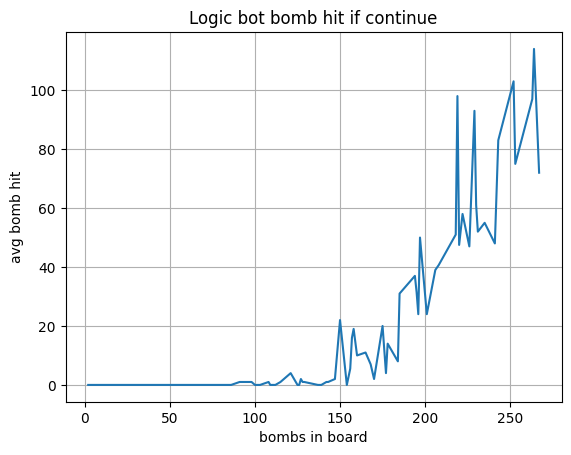

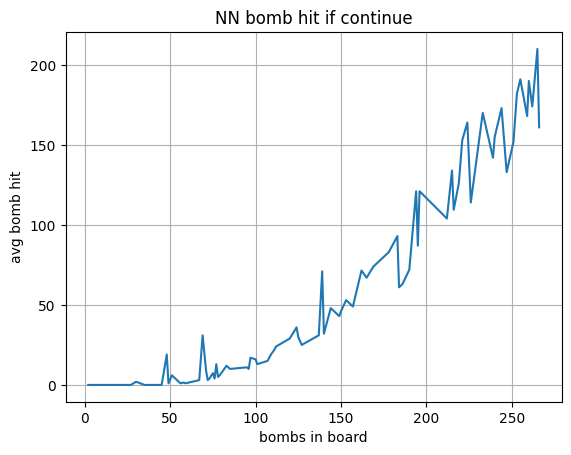

In [174]:
#Bombs hit 
plotData(lstBomb, "avg bomb hit", "Logic bot bomb hit if continue")

plotData(lstBombNN, "avg bomb hit", "NN bomb hit if continue")


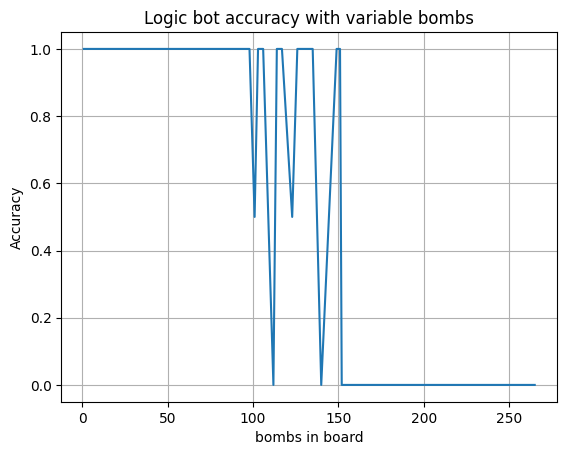

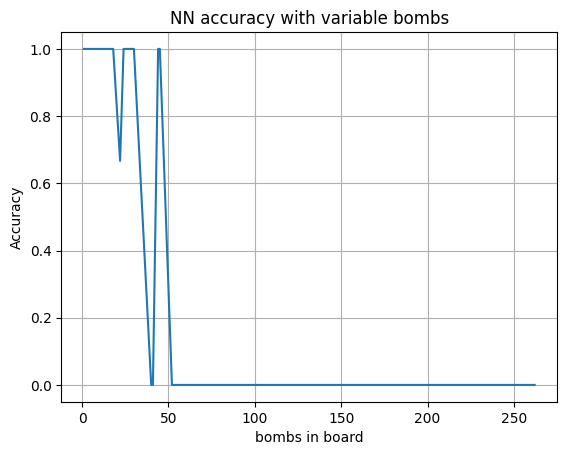

In [175]:
#Accuracy 
plotData(lstAccuracy, "Accuracy", "Logic bot accuracy with variable bombs")

plotData(lstAccuracyNN, "Accuracy", "NN accuracy with variable bombs")

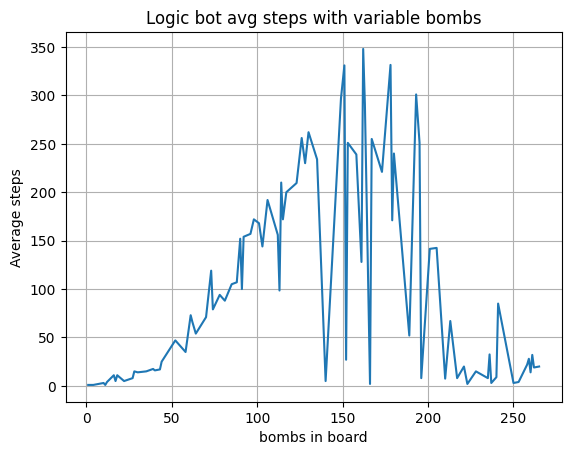

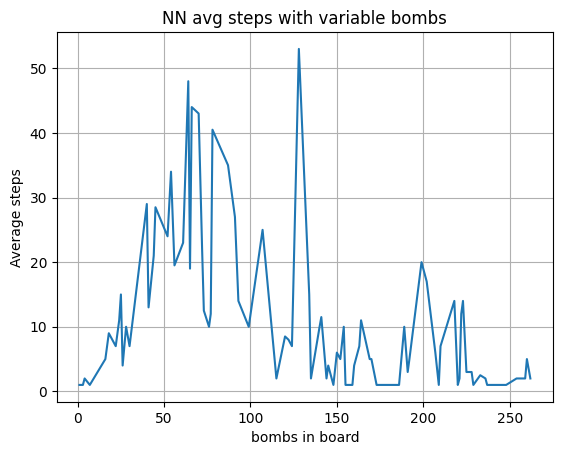

In [176]:
#steps  
plotData(lstSteps, "Average steps", "Logic bot avg steps with variable bombs")

plotData(lstStepsNN, "Average steps", "NN avg steps with variable bombs")

**Part 2 Variable Numbers of Mines writeup** 

When accessing varialbe amount of mines for a 30 x 30 board with 0-30% mines, the model, process of training and predicting the next move stays the same as set amount of mines. What is different is the data geneartion. To do this we can simply change the data to generate a random value from 0-.3 and multipy that by 30*30 to get mines on board. Simply just repeat that in data generation so that your data will consist of same board size of different mines. This is the simplest way to do it but in execution, a 30 x 30 board is too computationally difficult for data geneartion. It takes too long and the memory needed to store the data isn't enough. Instead I choose to train the data on a 9 x 9 board since this was the best results from part 1. Instead of training the whole board I simply need to train a part of the board and slide the input over the entire board. For training on the 9 x 9 board, although I am expecting to have a max of 30% mines there is a possibility that that window of 9 x 9 on the 30 x 30 board has more than 30% of the 9 x 9 area so in a realistic view I trained on 0 - 75 amount of mines. Then after training that model I needed to split the 30 x 30 board into sections of 9 x 9 and slided them by one. Each window is put into the model to predict which value is the mine and put back into a new probability map of the 30 x 30 board by taking the max of the corresponding cell. The max was choosen because perhaps another window that overlapped with that cell did not have enough information to determine that it was a mine so a new value will replace it. After getting the probability map we can just do what we did in part one and obtain the lowest cell to be a mine and open it. Repeat until bomb hit or game end. The accuracy is ~15 which is not bad for such a large board but looking at the graphs we can see most of the complete boards are from lower levels of mines. When making the graphs note that too little data/iterations where given because the computational time takes too long. Nevertheless, comparing the graphs, for bomb hit it seems that the NN is doing a lot worse since the total bomb it is hitting seems to be almost doule of the logic bot but follows a similar trend which is expected. Looking at the accuracy it is notable how the NN is doing well for low data points but starts getting worse when bombs increase at a earlier point than the logic bot. This can really be explained by not enought data points to support high bombs. Average steps seem to be just like the other graphs where the logic bot takes a lot more steps compared to the NN. Strucutre of the model is just the same for all questions since at the end it is a CNN, they are still all grids of cells. I didn't do much to imporve the training and overfitting except changing up the batch size and epochs which I found 64 batch size and 5 epoch to give the best results. The bot is inferior for find variable mines and this might be because I am not training on the whole board itself and also just like all other questions not enought data points.

Part 3 Variable Size Boards

In [274]:
#Test NN with Variable size, will be similar to part 2 except training data differs 
#Board will be square k x k where k >= 5 
#Comparison made on 5 - 50 with ~ 20% mines 

#Logic bot Varialbe size board 
default_factory = lambda: [0, 0]
lstBombVarBoard = defaultdict(default_factory)
lstAccuracyVarBoard = defaultdict(default_factory)
lstStepsVarBoard = defaultdict(default_factory)

totalGames = 1000
winCount = 0
totalSteps = 0 
for i in range(totalGames):
    boardSize = random.randrange(5, 51)
    bombs = int(boardSize*boardSize*.2)
    tupleVal = lstBombVarBoard[boardSize]
    tupleValStep = lstStepsVarBoard[boardSize]
    variableBoard = MinesweeperBoard(boardSize, boardSize, bombs) 
    bot = MinesweeperBot(variableBoard)
    steps, mines_triggered, lstMoves = bot.play_game()
    totalSteps += steps
    if mines_triggered == 0:
        winCount += 1
        tupleVal[0] += 1 
    tupleVal[1] += 1 
    lstAccuracyVarBoard[boardSize] = tupleVal
    tupleValStep[0] += steps
    tupleValStep[1] += 1 
    lstStepsVarBoard[boardSize] = tupleValStep
    
print("Bot Accuracy variable board:", winCount/totalGames)
print("Bot avg steps variable board:", totalSteps/totalGames)

mines_exploded = 0
for i in range(int(totalGames/2)):
    boardSize = random.randrange(5, 51)
    bombs = int(boardSize*boardSize*.2)
    variableBoard = MinesweeperBoard(boardSize, boardSize, bombs) 
    tupleVal = lstBombVarBoard[boardSize]
    bot = MinesweeperBot(variableBoard)
    cells_opened, mines_triggered = bot.play_game_nobomb()
    mines_exploded += mines_triggered
    tupleVal[0] += mines_triggered
    tupleVal[1] += 1 
    lstBombVarBoard[boardSize] = tupleVal

print("Bot avg mines exploded variable board:", mines_exploded/(int(totalGames/2)))


Bot Accuracy variable board: 0.045
Bot avg steps variable board: 174.815
Bot avg mines exploded variable board: 12.11


In [275]:
#Create training data 
X_data, y_data = create_training_data(5, 5, 5, int(.20*25))

for i in range(120000):
    percentage = random.uniform(0, .9)
    bombs = int(5*5*percentage)
    samplex, sampley = create_training_data(1, 5, 5, bombs)
    X_data = torch.cat((X_data, samplex),0)
    y_data = torch.cat((y_data, sampley),0)

print("Shape of x:", X_data.shape)
print("Shape of y:", y_data.shape)


Shape of x: torch.Size([148673, 5, 5, 10])
Shape of y: torch.Size([148673, 5, 5])


In [280]:
#Train Model

varBoardModel = CNNModel(5,5)

train_loader, test_loader = get_train_data(X_data, y_data, 5, 5)

varBoardModel = train_model(varBoardModel, train_loader, 5)

#Test a 5 x 5 using variable bomb so when sliding #bomb not guranteed 

gameCompleted = 0 
totalgames = 1000
for i in range(totalgames):
    percentage = random.uniform(0, .9)
    bombs = int(5*5*percentage)
    testModel = MinesweeperBoard(5, 5, bombs)
    completed = predict_next_move(varBoardModel, testModel, False)[0]
    if(completed):
        gameCompleted += 1 

print("Percent game completed:", gameCompleted/totalgames)


Epoch 1/5, Loss: 0.36650991584101694
Epoch 2/5, Loss: 0.3174676511991787
Epoch 3/5, Loss: 0.31195617907626966
Epoch 4/5, Loss: 0.3088423710731231
Epoch 5/5, Loss: 0.30673816999708087
Training finished.
Percent game completed: 0.258


In [ ]:
#Use variable bomb NN model over many inputs 

default_factory = lambda: [0, 0]
lstBombVarBoardNN = defaultdict(default_factory)
lstAccuracyVarBoardNN = defaultdict(default_factory)
lstStepsVarBoardNN = defaultdict(default_factory)

totalGames = 100
winCount = 0
totalSteps = 0 
for i in range(totalGames):
    boardSize = random.randrange(5, 51)
    bombs = int(boardSize*boardSize*.2)
    tupleVal = lstAccuracyVarBoardNN[boardSize]
    tupleValStep = lstStepsVarBoardNN[boardSize]
    variableBoard = MinesweeperBoard(boardSize, boardSize, bombs) 
    completed, steps = predict_minesweeper_slidingwindow(variableBoard, varBoardModel, 5, 5, 1, False)[:2]
    totalSteps += steps
    if completed:
        winCount += 1
        tupleVal[0] += 1 
    tupleVal[1] += 1 
    lstAccuracyVarBoardNN[boardSize] = tupleVal
    tupleValStep[0] += steps
    tupleValStep[1] += 1 
    lstStepsVarBoardNN[boardSize] = tupleValStep
    
print("NN Accuracy variable board:", winCount/totalGames)
print("NN avg steps variable board:", totalSteps/totalGames)

mines_exploded = 0
for i in range(totalGames):
    boardSize = random.randrange(5, 51)
    bombs = int(boardSize*boardSize*.2)
    variableBoard = MinesweeperBoard(30, 30, bombs)     
    tupleVal = lstBombVarBoardNN[boardSize]
    mines_triggered = predict_minesweeper_slidingwindow(variableBoard, varBoardModel, 5, 5, 1, True)[2]
    mines_exploded += mines_triggered
    tupleVal[0] += mines_triggered
    tupleVal[1] += 1 
    lstBombVarBoardNN[boardSize] = tupleVal

print("NN avg mines exploded variable board:", mines_exploded/totalGames)


###Note did not have time to run but if you rerun it will work just time issue takes too long to run 

In [285]:
def plotData2(lst, ylabelName, titleName):
    sorted_data = sorted(lst.items())
    x_values = [x for x, _ in sorted_data]
    y_values = [a / b for _, (a, b) in sorted_data]

    # Plot the function
    plt.plot(x_values, y_values)
    plt.xlabel('k x k - size of board')
    plt.ylabel(ylabelName)
    plt.title(titleName)
    plt.grid(True)
    plt.show()

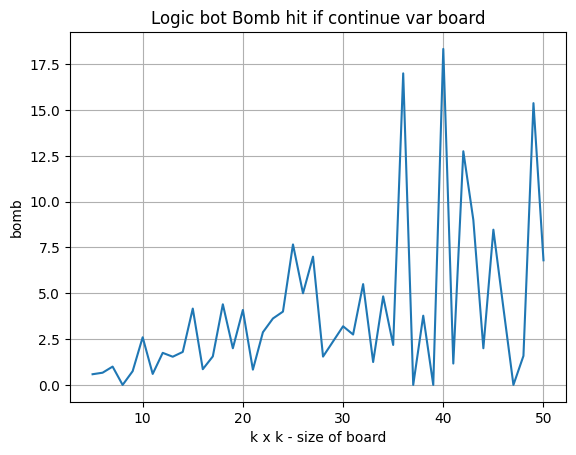

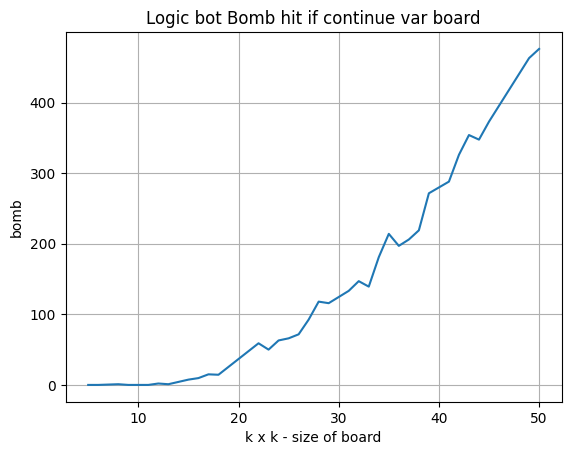

In [286]:
#Bombs hit 
plotData2(lstBombVarBoard, "bomb", "Logic bot Bomb hit if continue var board")

plotData2(lstBombVarBoardNN, "bomb", "Logic bot Bomb hit if continue var board")


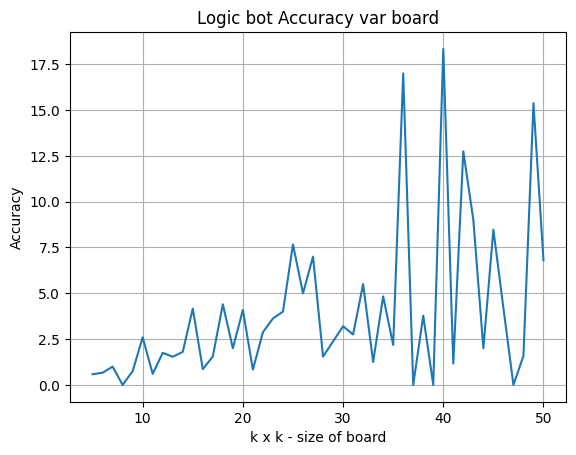

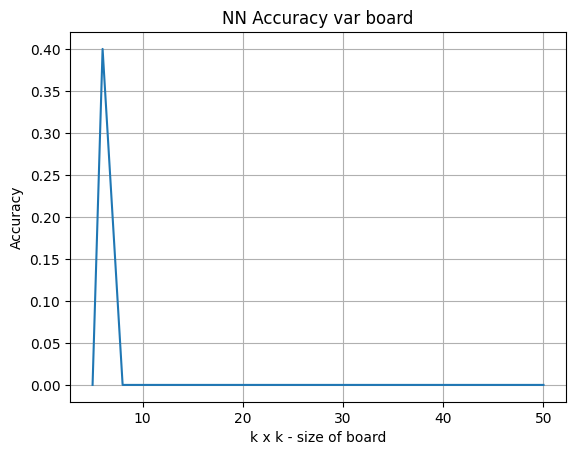

In [287]:
#Bombs hit 
plotData2(lstAccuracyVarBoard, "Accuracy", "Logic bot Accuracy var board")

plotData2(lstAccuracyVarBoardNN, "Accuracy", "NN Accuracy var board")


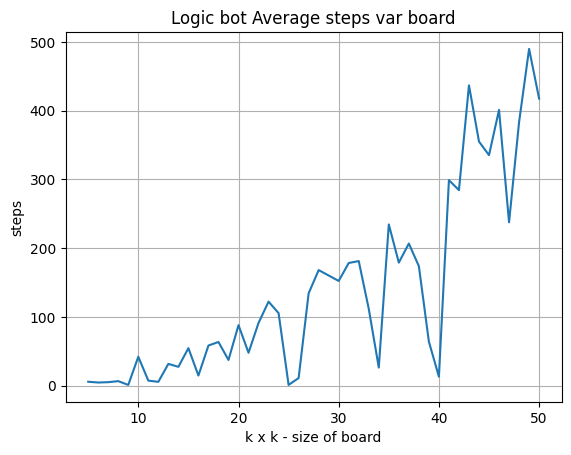

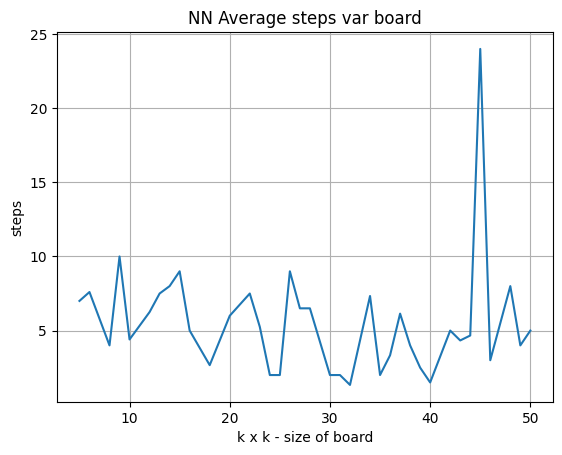

In [288]:
#Bombs hit 
plotData2(lstStepsVarBoard, "steps", "Logic bot Average steps var board")

plotData2(lstStepsVarBoardNN, "steps", "NN Average steps var board")


**Part 3 Variable Size Boards writeup** 

When considering the change in data and training data for variable size boards it does not seem that much different from what is done in part 2. Just like in part 2 the data will be variable size mines. This time the window is choosen to be a size of 5 since the boards can be any size greater than 5. Notice how the training data is the same from part 2 and nothing is changed to accommodate for the board size. This is because it is impossible to train for all possible boards since there is not limit on the size of the board. I can hard code the model to take in a max size of 50 boards but that way the model will no nothing about boards bigger than 50. So instead of changing data to take in random board sizes I did what I did in part 2 sliding the windows. Since I choose the method of sliding the window, as explained above, any size of input will suffice. Again the model doesn't have to change since what is more important is the data. The model will learn base on the data and having good and enough data will allow the model to process useful trends and patterns. Looking at the accuracy of the NN it seems to be slightly worse but not really as significant. It seems to me that the NN and the logic bot is pretty similiar. I think the biggest problem for the model to not perform as well is the issue of variable amount of mines. For every window you don't know how many mines there are so it is hard for the model to grasp a prediction for the spots where the mines should be. Also, perhaps a window size of 5 x 5 is too small to get all the information it needs to predict bombs but in further thought if we are sliding the window by one it helps capture more information. Technicology a 5 x 5 window is all you need for information in minesweeper. The model will be a lot better if the loss for just the 5 x 5 board with variable mines is minimized. From all 3 boards you can see that the NN is a lot worse than model having lower accuracy, higher bomb values and lower number of steps. Looking at the x axis it is very different but some of it have to do with not enought data points. Only did it for 100 times so one board might be around 50 x 50 while other is 5 x 5

Should the game be viewed sequentially, or does the current state of the game suffice?

I feel like the current state of the game is sufficient because learning the model sequentially is harder for the network. For minesweeper the only information that is neccessary is the state of the game and you don't really know what moves you have made in the past or how you got to this specific state. Doing it sequentially is simply throwing garbage information and a lot more information to the model to learn and interpret which might make the model worse. By providing the current state of the game as input to the neural network, you allow it to learn patterns and strategies based on the overall layout of the board, the positions of revealed and hidden cells, and other relevant information. 

Can attention be applied here in a useful way?

Attention is typically used for sequentially focusing on one thing and ignoring the rest. If the model was trained sequentially attention will be useful since a lot of time when you open a single cell you are not looking at the whole board but a small section of the surrounding mines. Nevertheless, although the training isn't sequentially, this concept of attention can be useful. If there is way to implement when looking at a individual cell more attention, higher values/weights, are allocated to the cells surrounding it and dimishes as it moves away. This way the model doesn't get a lot of useless information from very far away from the board confusing the model. 